In [18]:
from keras.layers          import Lambda, Input, Dense, GRU, LSTM, Dropout
from keras.models          import Model
from keras.layers.wrappers import Bidirectional
from keras.callbacks       import LambdaCallback 
from keras.optimizers      import Adam
from keras.layers.normalization import BatchNormalization as BN
import keras.backend as K
from keras.engine.topology import Layer
import random
import sys
from keras import initializers
import pickle
import glob
import copy
import os
import re
import MeCab
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from gensim.models import word2vec
import numpy as np
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Flatten
model = word2vec.Word2Vec.load('/mnt/sdc/wikipedia_data/jawiki_wakati.model')

In [19]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [20]:
addDict={}
seq_len=38
categories=9

In [21]:
def predictVector(word, around_words_list):
    global addDict
    if word in addDict:
        return addDict[word]
    else:
        return addUnknownWord(word,around_words_list)

def addUnknownWord(word , around_words_list):
    global addDict
    rand_vector=np.random.rand(200)/np.linalg.norm(np.random.rand(200))*(10+ 3*np.random.rand(1))
    vector=np.array(model[model.predict_output_word(around_words_list)[0][0]])+rand_vector
    addDict[word]=vector
    return vector
    
def Wakati(text):
    m = MeCab.Tagger ("-Ochasen -d /usr/lib/mecab/dic/mecab-ipadic-neologd -Owakati")
    result=m.parse(text)
    ws = re.compile(" ")
    words = [word for word in ws.split(result)]
    if words[-1] == u"\n":
        words = words[:-1]
    return [word for word in words if word!="「" and word!="」" and word!="、"]

def extractKeyword(text,word_class):
    tagger = MeCab.Tagger('-Ochasen')
    tagger.parse('') # <= 空文字列をparseする
    node = tagger.parseToNode(text)
    keywords = []
    while node:
        if node.feature.split(",")[0] == word_class:
            keywords.append(node.surface)
        node = node.next
    return keywords

def seq2vecs(words,predict):
    global addDict
    vectors=[]
    for i in range(len(words)):
            try:
                vectors.append(model[words[i]])
            except:
                if predict:
                    try:
                        vectors.append(predictVector(words[i],[words[i-1]]))
                    except:
                        if i==0:
                            return []
                        else:
                            similar_word=model.similar_by_vector(addDict[words[i-1]], topn=10, restrict_vocab=None)[0][0]
                            vectors.append(predictVector(words[i],[similar_word]))
                else:
                    return []
    return vectors

In [22]:
def train_test_divide(X,Y,T,test_rate):
    datanum=len(X)
    n=math.floor(datanum*test_rate)
    X_train=np.array(X[:datanum-n])
    Y_train=np.array(Y[:datanum-n])
    X_test=np.array(X[datanum-n:])
    Y_test=np.array(Y[datanum-n:])
    T_train=np.array(T[:datanum-n])
    T_test=np.array(T[datanum-n:])
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    print(len(T_train))
    print(len(T_test))
    return (X_train,Y_train,T_train),(X_test,Y_test,T_test)

In [23]:
def onehot_vector(number):
    global categories
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot

In [24]:
def load_data(filename,sfl,predict,extract):
    global seq_len
    X=[]
    Y=[]
    T=[]
    max_len=0
    with open(filename, "r") as f:
        lines = [line for line in f]
        for line in lines:
            title,category=line.split(" ")
            words=[]
            if extract:
                words=extractKeyword(title,"名詞")
            else:
                words=Wakati(title)
            input_vectors=seq2vecs(words,predict)
            max_len=max(max_len,len(input_vectors))
            if len(input_vectors) > seq_len:
                input_vectors=input_vectors[:seq_len]
            elif len(input_vectors)==0:
                continue
            if sfl:
                random.shuffle(input_vectors)
            x = [ [0.]*200 for _ in range(seq_len) ]
            x[0:len(input_vectors)]=input_vectors
            y=onehot_vector(int(category))
            X.append(np.array(x))
            Y.append(np.array(y))
            T.append(title)
    X,Y=shuffle(X,Y)
    X=np.array(X)
    Y=np.array(Y)
    print(X.shape)
    print(Y.shape)
    print(len(T))
    print(max_len)
    return X,Y,T

In [25]:
X,Y,T=load_data("./data/livedoor_data.txt",sfl=True,predict=False,extract=False)

/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(3873, 38, 200)
(3873, 9)
3873
38


In [26]:
(X_train,Y_train,T_train),(X_test,Y_test,T_test)=train_test_divide(X,Y,T,0.1)

(3486, 38, 200)
(3486, 9)
(387, 38, 200)
(387, 9)
3486
387


In [27]:
class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        self.W = K.variable(self.init((input_shape[-1],1)))
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)

    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x,self.W))
        eij=K.squeeze(eij,axis=2)
        ai = K.exp(eij)
        Sum=K.expand_dims(K.sum(ai, axis=1),axis=1)
        weights = ai/Sum
        weights=K.expand_dims(weights,axis=1)
        weighted_input = K.batch_dot(weights, x)
        weighted_input=K.squeeze(weighted_input,axis=1)
        return weighted_input

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [28]:
inputs      = Input(shape=(seq_len, 200))
encoded     = Bidirectional(LSTM(512,name="encoder",return_sequences=True,dropout=0.3))(inputs)
decoded    = AttLayer()(encoded)
preds     = Dense(categories,activation='softmax')(decoded)
model = Model(inputs=inputs, outputs=preds)
model.summary()
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=["accuracy"])
history =model.fit(X_train,Y_train,shuffle=True,batch_size=100,epochs=5,
                   validation_split=0.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 38, 200)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 38, 1024)          2920448   
_________________________________________________________________
att_layer_3 (AttLayer)       (None, 1024)              1024      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 9225      
Total params: 2,930,697
Trainable params: 2,930,697
Non-trainable params: 0
_________________________________________________________________
Train on 2440 samples, validate on 1046 samples
Epoch 1/5
2440/2440 [==============================] - 5s 2ms/step - loss: 1.5935 - acc: 0.4270 - val_loss: 1.1433 - val_acc: 0.6128
Epoch 2/5
2440/2440 [==============================] - 4s 2ms/step - loss: 0.9886 -

In [32]:
loss_and_metrics = model.evaluate(X_test,Y_test)
print("\nloss:{} accuracy:{}".format(loss_and_metrics[0],loss_and_metrics[1]))

387/387 [==============================] - 1s 2ms/step

loss:0.8584857712997946 accuracy:0.7364341085271318


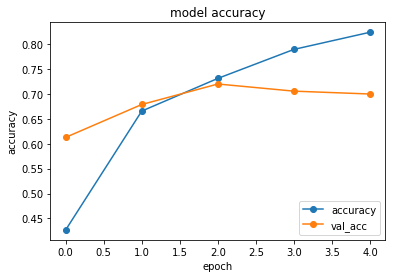

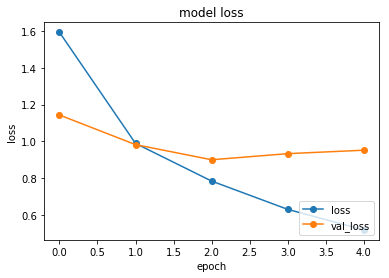

In [31]:
plot_history(history)